<a href="https://colab.research.google.com/github/CKristensen/OsloCityBikes_Analysis/blob/master/machine_learning/Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import psycopg2
import requests
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import time
import io
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.executing_eagerly()

from tensorflow.keras.layers import Dense, Input, Flatten, LSTM, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import concatenate

In [ ]:
# Database variabler
PASS = "password"
USER_NAME = "username"
HOST = "host-address"
DATABASE = "database"

# Create engine:
engine = create_engine(f'postgresql+psycopg2://{USER_NAME}:{PASS}@{HOST}/{DATABASE}')

# SQL query:
sql= '''select s.station_key,s.military_hour,s.trips_started,s.trips_ended, s.trips_ended+s.trips_started as all_trips,
s.air_temperatur_celsius, s.precipitation_mm, s.wind_speed_ms, s.date_actual, s.day_of_week, s.day_name, 
s.month_actual, s.day_of_month, s.quarter_actual, s.day_of_year, s.is_holiday, s.is_strike 
from star_old.stationtripslast s
where date_actual>='2019-04-01';'''

# Read in data from query to df
df_features= pd.read_sql_query(sql, engine, index_col=None)

# View all columns!
pd.set_option('display.max_columns', None)

# Make station_key numeric for easier merge later
df_features['station_key']=pd.to_numeric(df_features['station_key'])

print(df_features.head(5))
print(df_features.info())

   station_key  military_hour  trips_started  trips_ended  all_trips  \
0          509              1              0            0          0   
1          510              1              0            0          0   
2          511              1              0            0          0   
3          512              1              0            0          0   
4          513              1              0            0          0   

   air_temperatur_celsius  precipitation_mm  wind_speed_ms date_actual  \
0                     1.6               0.0            1.8  2019-04-02   
1                     1.6               0.0            1.8  2019-04-02   
2                     1.6               0.0            1.8  2019-04-02   
3                     1.6               0.0            1.8  2019-04-02   
4                     1.6               0.0            1.8  2019-04-02   

   day_of_week   day_name  month_actual  day_of_month  quarter_actual  \
0            2  Tuesday               4          

In [ ]:
ele=pd.read_csv('/elevation.csv')
ele=ele.rename(columns={'new':'station_key'})
ele.head(2)

,station_key,station_name,description,latitude_y,longitude_y,elevation_x
0,769,NaN,NaN,59.915553,10.751323,22.833595
1,767,NaN,NaN,59.918217,10.756065,16.531841


In [ ]:
df_merge= pd.merge(df_features,ele[['station_key','elevation_x']], on='station_key',how='left')

# Turning elevation back to string:
df_features['station_key']=df_features['station_key'].astype(str)


# Checking first and last date:
print(df_merge['date_actual'].min())
print(df_merge['date_actual'].max())

# Checking for null-values:
df_merge.isna().sum()

# Filling null-values by sea-level at 10m
df_merge['elevation_x']=df_merge['elevation_x'].fillna(10)


# Info
df_merge.head(5)
df_merge.info()
df_merge.describe()


2019-04-02
2020-09-30
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3485664 entries, 0 to 3485663
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   station_key             int64  
 1   military_hour           int64  
 2   trips_started           int64  
 3   trips_ended             int64  
 4   all_trips               int64  
 5   air_temperatur_celsius  float64
 6   precipitation_mm        float64
 7   wind_speed_ms           float64
 8   date_actual             object 
 9   day_of_week             int64  
 10  day_name                object 
 11  month_actual            int64  
 12  day_of_month            int64  
 13  quarter_actual          int64  
 14  day_of_year             int64  
 15  is_holiday              int64  
 16  is_strike               int64  
 17  elevation_x             float64
dtypes: float64(4), int64(12), object(2)
memory usage: 505.3+ MB


,station_key,military_hour,trips_started,trips_ended,all_trips,air_temperatur_celsius,precipitation_mm,wind_speed_ms,day_of_week,month_actual,day_of_month,quarter_actual,day_of_year,is_holiday,is_strike,elevation_x
count,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06,3.485664e+06
mean,5.383004e+02,1.150000e+01,9.790049e-01,9.790049e-01,1.958010e+00,9.837246e+00,2.675000e+00,2.863036e+00,3.984962e+00,6.515038e+00,1.622744e+01,2.505639e+00,1.834586e+02,1.635338e-01,1.879699e-02,4.606664e+01
std,1.596601e+02,6.922188e+00,2.226738e+00,2.437601e+00,4.224412e+00,7.187135e+00,4.950238e+00,1.573951e+00,1.997122e+00,2.983312e+00,8.539106e+00,9.567560e-01,9.117491e+01,3.698521e-01,1.358075e-01,2.896764e+01
min,3.770000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.450000e+00,0.000000e+00,1.142857e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
25%,4.460000e+02,5.750000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.914286e+00,0.000000e+00,1.642857e+00,2.000000e+00,4.000000e+00,9.000000e+00,2.000000e+00,1.147500e+02,0.000000e+00,0.000000e+00,2.187105e+01
50%,5.150000e+02,1.150000e+01,0.000000e+00,0.000000e+00,0.000000e+00,9.900000e+00,2.750000e-01,2.585714e+00,4.000000e+00,7.000000e+00,1.600000e+01,3.000000e+00,1.840000e+02,0.000000e+00,0.000000e+00,4.032841e+01
75%,5.840000e+02,1.725000e+01,1.000000e+00,1.000000e+00,2.000000e+00,1.540893e+01,3.050000e+00,3.814286e+00,6.000000e+00,9.000000e+00,2.400000e+01,3.000000e+00,2.520000e+02,0.000000e+00,0.000000e+00,6.369722e+01
max,1.919000e+03,2.300000e+01,1.200000e+02,2.410000e+02,2.640000e+02,3.130000e+01,3.210000e+01,1.194286e+01,7.000000e+00,1.200000e+01,3.100000e+01,4.000000e+00,3.650000e+02,1.000000e+00,1.000000e+00,1.378293e+02


In [ ]:
# Adding column saying if it's weekend or not:

df_merge['is_weekend']= np.where(df_merge['day_name'].isin(['Sunday','Saturday']),1,0)

df_merge['is_weekend'].head(5)

0    0
1    0
2    0
3    0
4    0
Name: is_weekend, dtype: int64

In [ ]:
# OHE av day_name:

days_encoder= OneHotEncoder(sparse=False)

days= df_merge[['day_name']]
print(days.head(10))

days_ohe= pd.DataFrame(days_encoder.fit_transform(days))
days_ohe.columns = days_encoder.get_feature_names(['day_name'])
print(days_ohe.head(5))



    day_name
0  Tuesday  
1  Tuesday  
2  Tuesday  
3  Tuesday  
4  Tuesday  
5  Tuesday  
6  Tuesday  
7  Tuesday  
8  Tuesday  
9  Tuesday  
   day_name_Friday     day_name_Monday     day_name_Saturday   \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   day_name_Sunday     day_name_Thursday   day_name_Tuesday    \
0                 0.0                 0.0                 1.0   
1                 0.0                 0.0                 1.0   
2                 0.0                 0.0                 1.0   
3                 0.0                 0.0                 1.0   
4                 0.0                 0.0                 1.0   

   day_name_Wednesday  
0                 0.0  
1                 0.0  
2  

Scaling date-values between 0 - 1:

In [ ]:
df_merge['month_actual']= df_merge['month_actual'].div(12)
df_merge['day_of_year']= df_merge['day_of_year'].div(365)
df_merge['day_of_week']= df_merge['day_of_week'].div(7)
df_merge['quarter_actual']= df_merge['quarter_actual'].div(4)
df_merge['military_hour']= df_merge['military_hour'].div(23)
df_merge['day_of_month']= df_merge['day_of_month'].div(31)


df_merge.head(5)

df_merge.max()

station_key                     1919
military_hour                      1
trips_started                    120
trips_ended                      241
all_trips                        264
air_temperatur_celsius          31.3
precipitation_mm                32.1
wind_speed_ms                11.9429
date_actual               2020-09-30
day_of_week                        1
day_name                   Wednesday
month_actual                       1
day_of_month                       1
quarter_actual                     1
day_of_year                        1
is_holiday                         1
is_strike                          1
elevation_x                  137.829
is_weekend                         0
dtype: object

Scaling all numerical columns so the value is between 0-1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7d93799b0>,
      dtype=object)

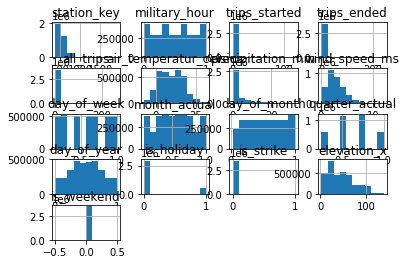

In [ ]:
# Showing max-values:
df_merge.max()

# Histogram av fordelingen
df_merge.hist()

# Need to scale wind_speed, air_temp, precipitation, elevation and all trips

In [ ]:
MinMax= MinMaxScaler()
all_trip=MinMax.fit_transform(df_merge[['all_trips']])
air_temp=MinMax.fit_transform(df_merge[['air_temperatur_celsius']])
precipitation=MinMax.fit_transform(df_merge[['precipitation_mm']])
wind=MinMax.fit_transform(df_merge[['wind_speed_ms']])
elevation=MinMax.fit_transform(df_merge[['elevation_x']])

# Adding scaled columns back to dataframe
df_merge['All_trips_scale']=all_trip
df_merge['Air_temperatur_scale']=air_temp
df_merge['precipitation_mm_scale']=precipitation
df_merge['wind_speed_ms_scale']=wind
df_merge['elevation_scale']=elevation

df_merge.head(2)

,station_key,military_hour,trips_started,trips_ended,all_trips,air_temperatur_celsius,precipitation_mm,wind_speed_ms,date_actual,day_of_week,day_name,month_actual,day_of_month,quarter_actual,day_of_year,is_holiday,is_strike,elevation_x,is_weekend,All_trips_scale,Air_temperatur_scale,precipitation_mm_scale,wind_speed_ms_scale,elevation_scale
0,509,0.043478,0,0,0,1.6,0.0,1.8,2019-04-02,0.285714,Tuesday,0.333333,0.064516,0.5,0.252055,0,0,26.864119,0,0.0,0.233548,0.0,0.142512,0.183054
1,510,0.043478,0,0,0,1.6,0.0,1.8,2019-04-02,0.285714,Tuesday,0.333333,0.064516,0.5,0.252055,0,0,89.752731,0,0.0,0.233548,0.0,0.142512,0.646052


Turn station key back to categorical value

In [ ]:
df_merge['station_key']=df_merge['station_key'].astype('category')
df_merge.dtypes

station_key               category
military_hour              float64
trips_started                int64
trips_ended                  int64
all_trips                    int64
air_temperatur_celsius     float64
precipitation_mm           float64
wind_speed_ms              float64
date_actual                 object
day_of_week                float64
day_name                    object
month_actual               float64
day_of_month               float64
quarter_actual             float64
day_of_year                float64
is_holiday                   int64
is_strike                    int64
elevation_x                float64
is_weekend                   int64
All_trips_scale            float64
Air_temperatur_scale       float64
precipitation_mm_scale     float64
wind_speed_ms_scale        float64
elevation_scale            float64
dtype: object

Label encode station key to values between 1 and 273:

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_station = LabelEncoder()

df_merge['station_key_code']= lb_station.fit_transform(df_merge['station_key'])

# Add 1 so min. value is 1:
df_merge['station_key_code']=df_merge['station_key_code'].add(1)
df_merge[['station_key','station_key_code']].sort_values(by='station_key_code')

,station_key,station_key_code
2644694,377,1
2823509,377,1
1882478,377,1
316004,377,1
3024710,377,1
...,...,...
746797,1919,273
2658343,1919,273
747070,1919,273
2660254,1919,273


In [ ]:
# Creating final df:
df_merge.columns

df_all= df_merge[['station_key_code', 'military_hour',
       'all_trips', 'Air_temperatur_scale', 'precipitation_mm_scale',
       'wind_speed_ms_scale', 'elevation_scale', 'date_actual', 'day_of_week',
       'month_actual', 'day_of_month', 'quarter_actual', 'day_of_year',
       'is_holiday', 'is_weekend']]

df_all.info()

df_all

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3485664 entries, 0 to 3485663
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   station_key_code        int64  
 1   military_hour           float64
 2   all_trips               int64  
 3   Air_temperatur_scale    float64
 4   precipitation_mm_scale  float64
 5   wind_speed_ms_scale     float64
 6   elevation_scale         float64
 7   date_actual             object 
 8   day_of_week             float64
 9   month_actual            float64
 10  day_of_month            float64
 11  quarter_actual          float64
 12  day_of_year             float64
 13  is_holiday              int64  
 14  is_weekend              int64  
dtypes: float64(10), int64(4), object(1)
memory usage: 425.5+ MB


,station_key_code,military_hour,all_trips,Air_temperatur_scale,precipitation_mm_scale,wind_speed_ms_scale,elevation_scale,date_actual,day_of_week,month_actual,day_of_month,quarter_actual,day_of_year,is_holiday,is_weekend
0,131,0.043478,0,0.233548,0.0,0.142512,0.183054,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
1,132,0.043478,0,0.233548,0.0,0.142512,0.646052,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
2,133,0.043478,0,0.233548,0.0,0.142512,0.253313,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
3,134,0.043478,0,0.233548,0.0,0.142512,0.448399,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
4,135,0.043478,0,0.233548,0.0,0.142512,0.742938,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485659,126,0.043478,0,0.233548,0.0,0.142512,0.014724,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
3485660,127,0.043478,0,0.233548,0.0,0.142512,0.488565,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
3485661,128,0.043478,0,0.233548,0.0,0.142512,0.212228,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0
3485662,129,0.043478,0,0.233548,0.0,0.142512,0.158294,2019-04-02,0.285714,0.333333,0.064516,0.5,0.252055,0,0


In [ ]:
# Set index to date and reset index:
df_all= df_all.set_index('date_actual').sort_index()
print(df_all.head(10))

# Train, test, split:
split_date = pd.to_datetime('2020-08-01').date()
train= df_all.loc[df_all.index <= split_date].copy()
test= df_all.loc[df_all.index > split_date].copy()

#Sjekker at splitten er riktig
print(test.head(5))
print(train.head(6))

# Split into x and y:
y_train= train['all_trips']
x_train = train.loc[:,train.columns!='all_trips']

y_test= test['all_trips']
x_test = test.loc[:,test.columns!='all_trips']



             station_key_code  military_hour  all_trips  Air_temperatur_scale  \
date_actual                                                                     
2019-04-02                131       0.043478          0              0.233548   
2019-04-02                136       0.739130          0              0.396129   
2019-04-02                135       0.739130          0              0.396129   
2019-04-02                134       0.739130          0              0.396129   
2019-04-02                133       0.739130          0              0.396129   
2019-04-02                132       0.739130          0              0.396129   
2019-04-02                131       0.739130          0              0.396129   
2019-04-02                130       0.739130          0              0.396129   
2019-04-02                129       0.739130          0              0.396129   
2019-04-02                128       0.739130          0              0.396129   

             precipitation_

Turn test & training data into numpy array

In [ ]:
# Separate input 1 and 2 from test & training. Turn into np.array

x_train_2= x_train.loc[:,x_train.columns !='station_key_code'].values.astype('float32')
x_train_1= x_train[['station_key_code']].values

x_test_2= x_test.loc[:,x_test.columns !='station_key_code'].values.astype('float32')
x_test_1= x_test[['station_key_code']].values

Y_test= y_test.values.reshape(-1,1).astype('float32')
Y_train= y_train.values.reshape(-1,1).astype('float32')


In [ ]:
print(x_train_2.shape)
print(x_train_1.shape)
print(Y_test.shape)
print(Y_train.shape)

(3092544, 12)
(3092544, 1)
(393120, 1)
(3092544, 1)


Building the model:


In [ ]:
from tensorflow.keras.layers import Embedding

# For input 1:
input1= Input(shape=(1,))
print(f'input1: {input1.shape}')
embed_layer= Embedding(input_dim= 273, input_length=1, output_dim=16, name='station-id-lookup')(input1)
print(f'embed_layer: {embed_layer.shape}')
flatten_layer=Flatten()(embed_layer)
print(f'flatten_layer: {flatten_layer.shape}')
input2= Input(shape=(12,))
print(f'input2: {input2.shape}')

input1: (None, 1)
embed_layer: (None, 1, 16)
flatten_layer: (None, 16)
input2: (None, 12)


In [ ]:
# Count number of unique values:
df_all['station_key_code'].max()

from keras.layers import Embedding

# For input 1:
input1= Input(shape=(1,))
embed_layer= Embedding(input_dim= 274, input_length=1, output_dim=16, name='station-id-lookup')(input1)
flatten_layer=Flatten()(embed_layer)

# For input 2:
input2= Input(shape=(12,))

# Combine output of the two branches (input1 and input2)
combine = concatenate([flatten_layer, input2])

# Hidden layers
hidden_layer1= Dense(64, activation='relu')(combine)
hidden_layer2= Dense(16, activation='relu')(hidden_layer1)
output_layer = Dense(1, activation='linear')(flatten_layer)

# Create & compile model
model_OBS = Model(inputs = [input1,input2], outputs=output_layer)

model_OBS.compile(optimizer='adam', loss='mse', metrics='mae')



# Trener modellen:
history = model_OBS.fit([x_train_1, x_train_2], Y_train, 
    batch_size=128, epochs=3,
    validation_data=([x_test_1,x_test_2],Y_test))


Epoch 1/3
24161/24161 [==============================] - 27s 1ms/step - loss: 2.2064e-04 - mae: 0.0087 - val_loss: 2.7034e-04 - val_mae: 0.0098
Epoch 2/3
24161/24161 [==============================] - 28s 1ms/step - loss: 2.1828e-04 - mae: 0.0086 - val_loss: 2.8186e-04 - val_mae: 0.0094
Epoch 3/3
24161/24161 [==============================] - 30s 1ms/step - loss: 2.1826e-04 - mae: 0.0086 - val_loss: 2.7521e-04 - val_mae: 0.0094


In [ ]:

input1= Input(shape=(1,))
embed_layer= Embedding(input_dim= 274, input_length=1, 
                       output_dim=16, name='station-id-lookup')(input1)
flatten_layer=Flatten()(embed_layer)

input2= Input(shape=(12,))
combine = concatenate([flatten_layer, input2])

hidden_layer1= Dense(64, activation='relu')(combine)
hidden_layer2= Dense(32, activation='relu')(hidden_layer1)
hidden_layer3= Dense(10, activation='relu')(hidden_layer2)
output_layer = Dense(1, activation='linear')(hidden_layer3)

# Create & compile model
model3_OBS = Model(inputs = [input1,input2], outputs=output_layer)
model3_OBS.compile(optimizer='adam', loss='mse', metrics='mae')


# Trener modellen:
history = model3_OBS.fit([x_train_1, x_train_2], Y_train, 
    batch_size=128, epochs=20, 
    validation_data=([x_test_1,x_test_2],Y_test))


Epoch 1/20
24161/24161 [==============================] - 38s 2ms/step - loss: 8.4403 - mae: 1.4647 - val_loss: 11.9297 - val_mae: 2.0526
Epoch 2/20
24161/24161 [==============================] - 37s 2ms/step - loss: 6.7510 - mae: 1.3011 - val_loss: 15.6240 - val_mae: 2.2281
Epoch 3/20
24161/24161 [==============================] - 37s 2ms/step - loss: 6.2682 - mae: 1.2531 - val_loss: 13.3831 - val_mae: 2.1134
Epoch 4/20
24161/24161 [==============================] - 37s 2ms/step - loss: 6.0432 - mae: 1.2287 - val_loss: 15.7936 - val_mae: 2.1817
Epoch 5/20
24161/24161 [==============================] - 38s 2ms/step - loss: 5.8884 - mae: 1.2113 - val_loss: 12.9111 - val_mae: 2.0491
Epoch 6/20
24161/24161 [==============================] - 38s 2ms/step - loss: 5.7631 - mae: 1.1979 - val_loss: 14.4553 - val_mae: 2.1479
Epoch 7/20
24161/24161 [==============================] - 38s 2ms/step - loss: 5.6745 - mae: 1.1878 - val_loss: 13.6544 - val_mae: 2.1227
Epoch 8/20
24161/24161 [==========

Plotter loss vs mae

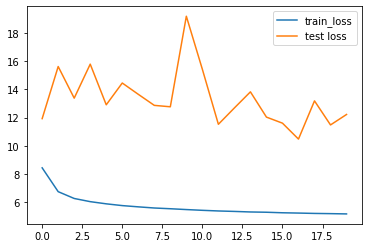

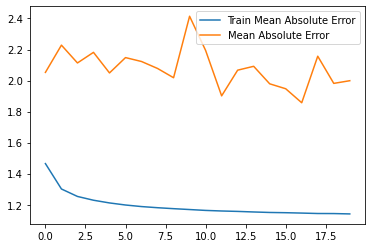

In [ ]:
# make each plot seperatly 
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend(loc='upper right')
plt.show()

# make each plot seperatly 
plt.plot(history.history['mae'], label='Train Mean Absolute Error')
plt.plot(history.history['val_mae'], label='Mean Absolute Error')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Make predictions!

y_test_pred = model3_OBS.predict([x_test_1, x_test_2])



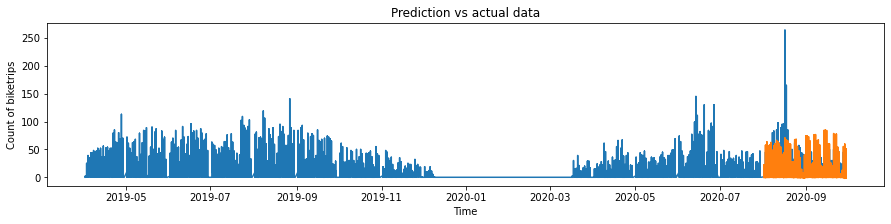

In [ ]:
# All data vs predicted data for test:
plt.figure(figsize=(15,3))
plt.title("Prediction vs actual data")
plt.xlabel("Time")
plt.ylabel("Count of biketrips")
plt.plot(df_all.index, df_all['all_trips'])
plt.plot(x_test.index, y_test_pred, label="prediction")

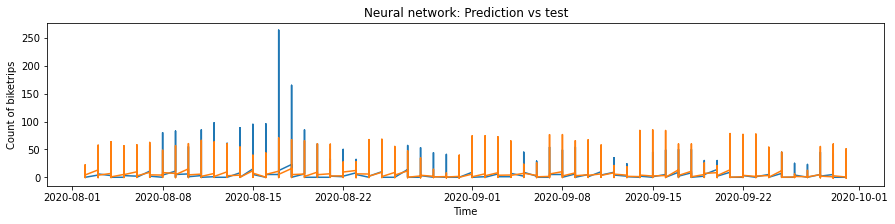

In [ ]:
plt.figure(figsize=(15,3))
plt.title("Neural network: Prediction vs test")
plt.xlabel("Time")
plt.ylabel("Count of biketrips")
plt.plot(x_test.index, y_test, label='test')
plt.plot(x_test.index, y_test_pred, label="prediction")